In [36]:
import foolbox as fb
import art
import art.utils
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
import numpy as np
import joblib
import matplotlib.pyplot as plt 
# import eagerpy as ep

import art.utils

# patch to 
def _to_categorical_patch(y, nb_classes=None, **kwargs):
    # If y is 1D or (N,1), just return as is (for binary)
    if y.ndim == 1 or (y.ndim == 2 and y.shape[1] == 1):
        return y
    return art.utils.original_to_categorical(y, nb_classes, **kwargs)

art.utils.original_to_categorical = art.utils.to_categorical
art.utils.to_categorical = _to_categorical_patch

print(tf.__version__)
print(art.__version__)

print(tf.__version__)
print(art.__version__)


2.19.0
1.20.0
2.19.0
1.20.0


In [37]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')
# print(X_train[1])
print(Y_train.shape)

(159042,)


In [38]:
from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_ciciot_updated_model.keras')
lstm_loaded = load_model('../../models/lstm_ciciot_updated_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_ciciot_updated_model.keras')


### Defining evaluation metrics functions

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import time

def evaluate(true_labels, pred_labels, title):
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, zero_division=0)
    rec = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    print(f"--- {title} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print()
    return(acc, prec, rec, f1)

### Plots functions

In [40]:
import matplotlib.pyplot as plt

def plot_metrics(epsilons, fgsm_vals, pgd_vals, save_path=None, title_prefix=''):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy
    axes[0, 0].plot(epsilons, fgsm_vals['acc'], label='FGSM - Accuracy', marker='o', linestyle='-', color='tab:blue')
    axes[0, 0].plot(epsilons, pgd_vals['acc'], label='PGD - Accuracy', marker='s', linestyle='--', color='tab:orange')
    axes[0, 0].set_xlabel('Epsilon')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy vs Epsilon')
    axes[0, 0].set_xlim(left=0.0)
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    # Precision
    axes[0, 1].plot(epsilons, fgsm_vals['prec'], label='FGSM - Precision', marker='o', linestyle='-', color='tab:blue')
    axes[0, 1].plot(epsilons, pgd_vals['prec'], label='PGD - Precision', marker='s', linestyle='--', color='tab:orange')
    axes[0, 1].set_xlabel('Epsilon')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision vs Epsilon')
    axes[0, 1].set_xlim(left=0.0)
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    # Recall
    axes[1, 0].plot(epsilons, fgsm_vals['rec'], label='FGSM - Recall', marker='o', linestyle='-', color='tab:blue')
    axes[1, 0].plot(epsilons, pgd_vals['rec'], label='PGD - Recall', marker='s', linestyle='--', color='tab:orange')
    axes[1, 0].set_xlabel('Epsilon')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Recall vs Epsilon')
    axes[1, 0].set_xlim(left=0.0)
    axes[1, 0].set_ylim(0, 1.05)
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    # F1-score
    axes[1, 1].plot(epsilons, fgsm_vals['f1'], label='FGSM - F1-score', marker='o', linestyle='-', color='tab:blue')
    axes[1, 1].plot(epsilons, pgd_vals['f1'], label='PGD - F1-score', marker='s', linestyle='--', color='tab:orange')
    axes[1, 1].set_xlabel('Epsilon')
    axes[1, 1].set_ylabel('F1-score')
    axes[1, 1].set_title('F1-score vs Epsilon')
    axes[1, 1].set_xlim(left=0.0)
    axes[1, 1].set_ylim(0, 1.05)
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    fig.suptitle(f"{title_prefix} Metrics under Adversarial Attacks", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


def plot_roc(fgsm_tpr, fgsm_fpr, pgd_tpr, pgd_fpr, fgsm_auc, pgd_auc, filename):
    plt.figure(figsize=(8, 6))
    plt.plot(fgsm_fpr, fgsm_tpr, label=f'FGSM (AUC = {fgsm_auc:.4f})', color='tab:blue')
    plt.plot(pgd_fpr, pgd_tpr, label=f'PGD (AUC = {pgd_auc:.4f})', color='tab:orange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CICIOT ROC Curve - Attack (epsilon=1.0)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.show()
    plt.close()


### Adversarial attacks functions

In [41]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BoundaryAttack, HopSkipJump, SimBA
from art.estimators.classification import KerasClassifier

def run_adversarial_evaluation(model, model_name, X, Y, epsilons, clip_values, results_location):
    classifier = KerasClassifier(model=model, clip_values=clip_values, use_logits=False)

    preds = classifier.predict(X)
    labels = (preds > 0.5).astype(int).flatten()
    correct = labels == Y.flatten()
    X_correct = X[correct]
    Y_correct = Y[correct]
    classifier = KerasClassifier(model=model, clip_values=(X_correct.min(), X_correct.max()), use_logits=False)
    if Y_correct.ndim == 1:
        Y_correct = Y_correct.reshape(-1, 1)

    fgsm_acc, fgsm_prec, fgsm_rec, fgsm_f1 = [], [], [], []
    pgd_acc, pgd_prec, pgd_rec, pgd_f1 = [], [], [], []

    # FGSM
    for i, eps in enumerate(epsilons):
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        adv = attack.generate(x=X_correct, y=Y_correct)
        preds_adv = classifier.predict(adv)
        labels_adv = (preds_adv > 0.5).astype(int).flatten()
        acc, prec, rec, f1 = evaluate(Y_correct, labels_adv, f"{model_name} FGSM - {eps*100:.2f}%")
        fgsm_acc.append(acc), fgsm_prec.append(prec), fgsm_rec.append(rec), fgsm_f1.append(f1)

        if eps == 1.0:
            fgsm_fpr, fgsm_tpr, _ = roc_curve(Y_correct, labels_adv)
            fgsm_roc_auc = auc(fgsm_fpr, fgsm_tpr)

    # PGD
    for i, eps in enumerate(epsilons):
        attack = ProjectedGradientDescent(estimator=classifier, eps=eps, verbose=False)
        adv = attack.generate(x=X_correct, y=Y_correct)
        preds_adv = classifier.predict(adv)
        labels_adv = (preds_adv > 0.5).astype(int).flatten()
        acc, prec, rec, f1 = evaluate(Y_correct, labels_adv, f"{model_name} PGD - {eps*100:.2f}%")
        pgd_acc.append(acc), pgd_prec.append(prec), pgd_rec.append(rec), pgd_f1.append(f1)

        if eps == 1.0:
            pgd_fpr, pgd_tpr, _ = roc_curve(Y_correct, labels_adv)
            pgd_roc_auc = auc(pgd_fpr, pgd_tpr)

    # # Plots
    # plot_metrics(epsilons, fgsm_acc, pgd_acc, 'Accuracy', f"{results_location}_accuracy.png")
    # plot_metrics(epsilons, fgsm_prec, pgd_prec, 'Precision', f"{results_location}_precision.png")
    # plot_metrics(epsilons, fgsm_rec, pgd_rec, 'Recall', f"{results_location}_recall.png")
    # plot_metrics(epsilons, fgsm_f1, pgd_f1, 'F1-score', f"{results_location}_f1.png")
    fgsm_vals = {'acc': fgsm_acc, 'prec': fgsm_prec, 'rec': fgsm_rec, 'f1': fgsm_f1}
    pgd_vals = {'acc': pgd_acc, 'prec': pgd_prec, 'rec': pgd_rec, 'f1': pgd_f1}

    plot_metrics(epsilons, fgsm_vals, pgd_vals, save_path=f'{results_location}_metrics.png', title_prefix= f'{model_name} CICIOT')


    if fgsm_roc_auc and pgd_roc_auc:
        plot_roc(fgsm_tpr, fgsm_fpr, pgd_tpr, pgd_fpr, fgsm_roc_auc, pgd_roc_auc, f"{results_location}_roc.png")

### Parameters

In [42]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0]
clip_vals = (X_test.min(), X_test.max())

### CNN

--- CNN FGSM - 1.00% ---
Accuracy : 0.9964
Precision: 1.0000
Recall   : 0.9930
F1-score : 0.9965

--- CNN FGSM - 5.00% ---
Accuracy : 0.9270
Precision: 0.9467
Recall   : 0.9077
F1-score : 0.9268

--- CNN FGSM - 10.00% ---
Accuracy : 0.3949
Precision: 0.3897
Recall   : 0.3350
F1-score : 0.3603

--- CNN FGSM - 20.00% ---
Accuracy : 0.2474
Precision: 0.1277
Recall   : 0.0822
F1-score : 0.1001

--- CNN FGSM - 30.00% ---
Accuracy : 0.2413
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

--- CNN FGSM - 60.00% ---
Accuracy : 0.3153
Precision: 0.0029
Recall   : 0.0010
F1-score : 0.0015

--- CNN FGSM - 80.00% ---
Accuracy : 0.3495
Precision: 0.0106
Recall   : 0.0030
F1-score : 0.0047

--- CNN FGSM - 100.00% ---
Accuracy : 0.3990
Precision: 0.0262
Recall   : 0.0050
F1-score : 0.0084

--- CNN PGD - 1.00% ---
Accuracy : 0.9964
Precision: 1.0000
Recall   : 0.9930
F1-score : 0.9965

--- CNN PGD - 5.00% ---
Accuracy : 0.9750
Precision: 0.9721
Recall   : 0.9789
F1-score : 0.9755

--- CNN PGD - 1

FileNotFoundError: [Errno 2] No such file or directory: '../../results/CICIOT/attacks/CNN_metrics.png'

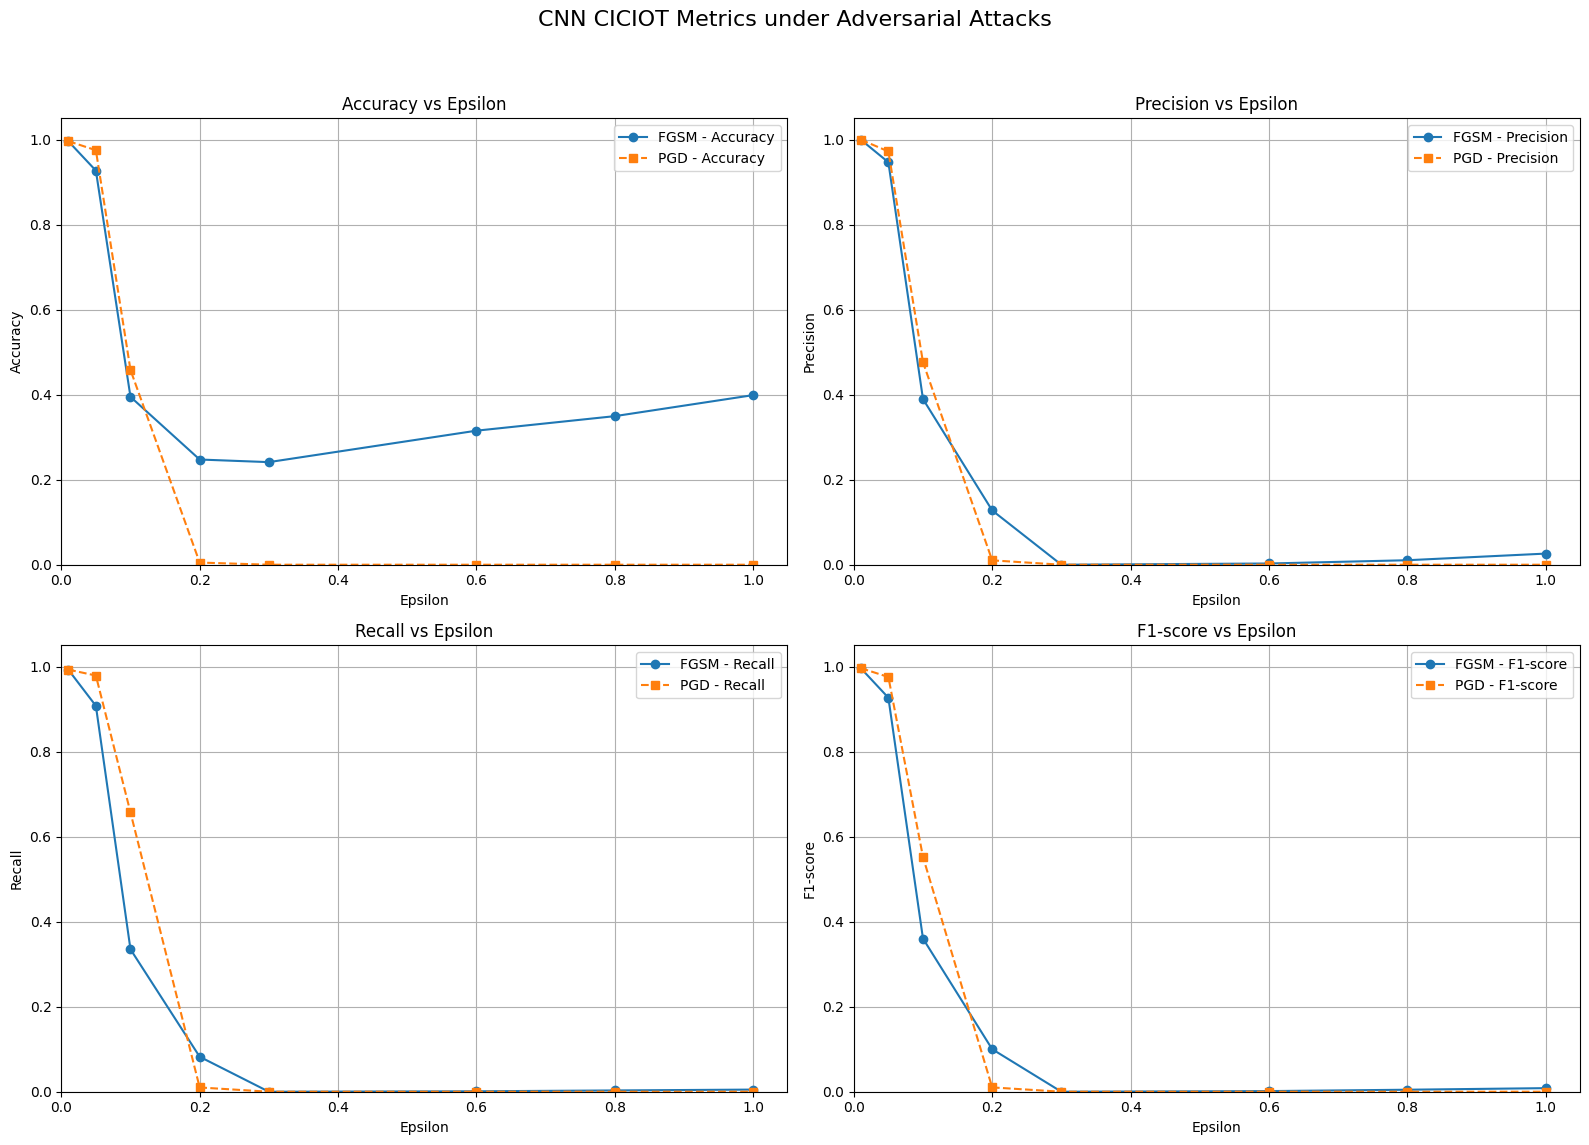

In [ ]:
run_adversarial_evaluation(cnn_loaded, "CNN", X_test[:2000], Y_test[:2000], epsilons, clip_vals, "../../results/CICIOT_updated/attacks/CNN")

### LSTM

--- LSTM FGSM - 1.00% ---
Accuracy : 0.9995
Precision: 1.0000
Recall   : 0.9990
F1-score : 0.9995

--- LSTM FGSM - 5.00% ---
Accuracy : 0.9887
Precision: 0.9899
Recall   : 0.9879
F1-score : 0.9889

--- LSTM FGSM - 10.00% ---
Accuracy : 0.8893
Precision: 0.8312
Recall   : 0.9808
F1-score : 0.8998

--- LSTM FGSM - 20.00% ---
Accuracy : 0.5768
Precision: 0.5650
Recall   : 0.7159
F1-score : 0.6316

--- LSTM FGSM - 30.00% ---
Accuracy : 0.5272
Precision: 0.5283
Recall   : 0.6229
F1-score : 0.5717

--- LSTM FGSM - 60.00% ---
Accuracy : 0.2572
Precision: 0.0755
Recall   : 0.0415
F1-score : 0.0535

--- LSTM FGSM - 80.00% ---
Accuracy : 0.2787
Precision: 0.0571
Recall   : 0.0273
F1-score : 0.0369

--- LSTM FGSM - 100.00% ---
Accuracy : 0.2797
Precision: 0.0251
Recall   : 0.0111
F1-score : 0.0154

--- LSTM PGD - 1.00% ---
Accuracy : 0.9995
Precision: 1.0000
Recall   : 0.9990
F1-score : 0.9995

--- LSTM PGD - 5.00% ---
Accuracy : 0.9841
Precision: 0.9809
Recall   : 0.9879
F1-score : 0.9844

--- L

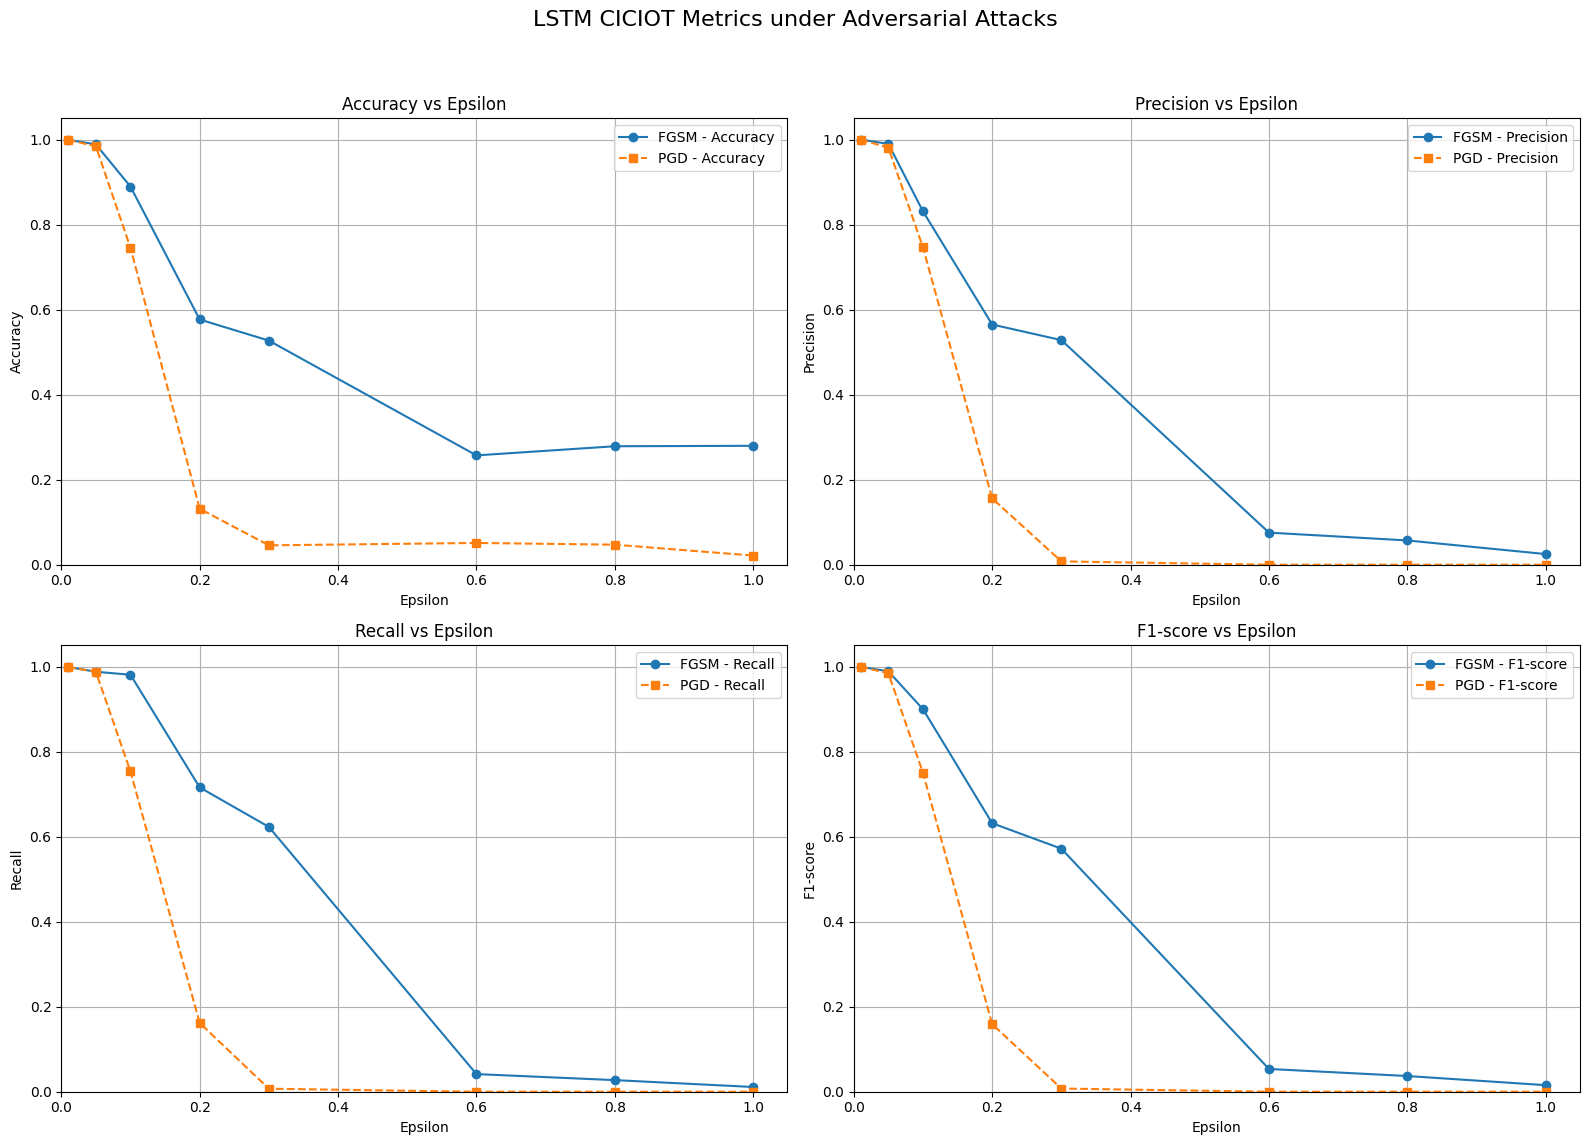

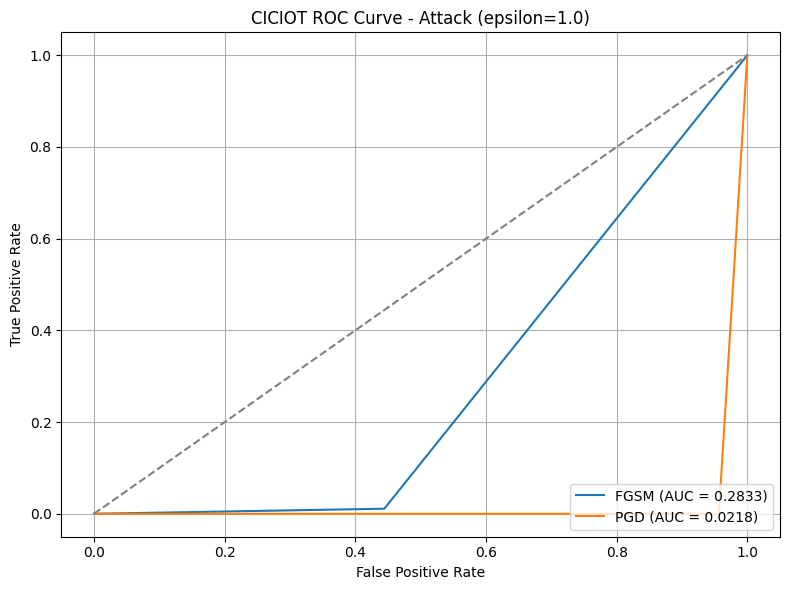

In [44]:
run_adversarial_evaluation(lstm_loaded, "LSTM", X_test[:2000], Y_test[:2000], epsilons, clip_vals, "../../results/CICIOT_updated/attacks/LSTM")

### AE-LSTM

--- AE-LSTM FGSM - 1.00% ---
Accuracy : 0.9959
Precision: 0.9958
Recall   : 0.9958
F1-score : 0.9958

--- AE-LSTM FGSM - 5.00% ---
Accuracy : 0.9466
Precision: 0.9243
Recall   : 0.9707
F1-score : 0.9469

--- AE-LSTM FGSM - 10.00% ---
Accuracy : 0.4887
Precision: 0.4853
Recall   : 0.6904
F1-score : 0.5699

--- AE-LSTM FGSM - 20.00% ---
Accuracy : 0.0903
Precision: 0.1507
Recall   : 0.1841
F1-score : 0.1657

--- AE-LSTM FGSM - 30.00% ---
Accuracy : 0.0021
Precision: 0.0040
Recall   : 0.0042
F1-score : 0.0041

--- AE-LSTM FGSM - 60.00% ---
Accuracy : 0.0678
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

--- AE-LSTM FGSM - 80.00% ---
Accuracy : 0.1807
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

--- AE-LSTM FGSM - 100.00% ---
Accuracy : 0.2033
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

--- AE-LSTM PGD - 1.00% ---
Accuracy : 0.9959
Precision: 0.9958
Recall   : 0.9958
F1-score : 0.9958

--- AE-LSTM PGD - 5.00% ---
Accuracy : 0.9363
Precision: 0.9062
Recall   : 0

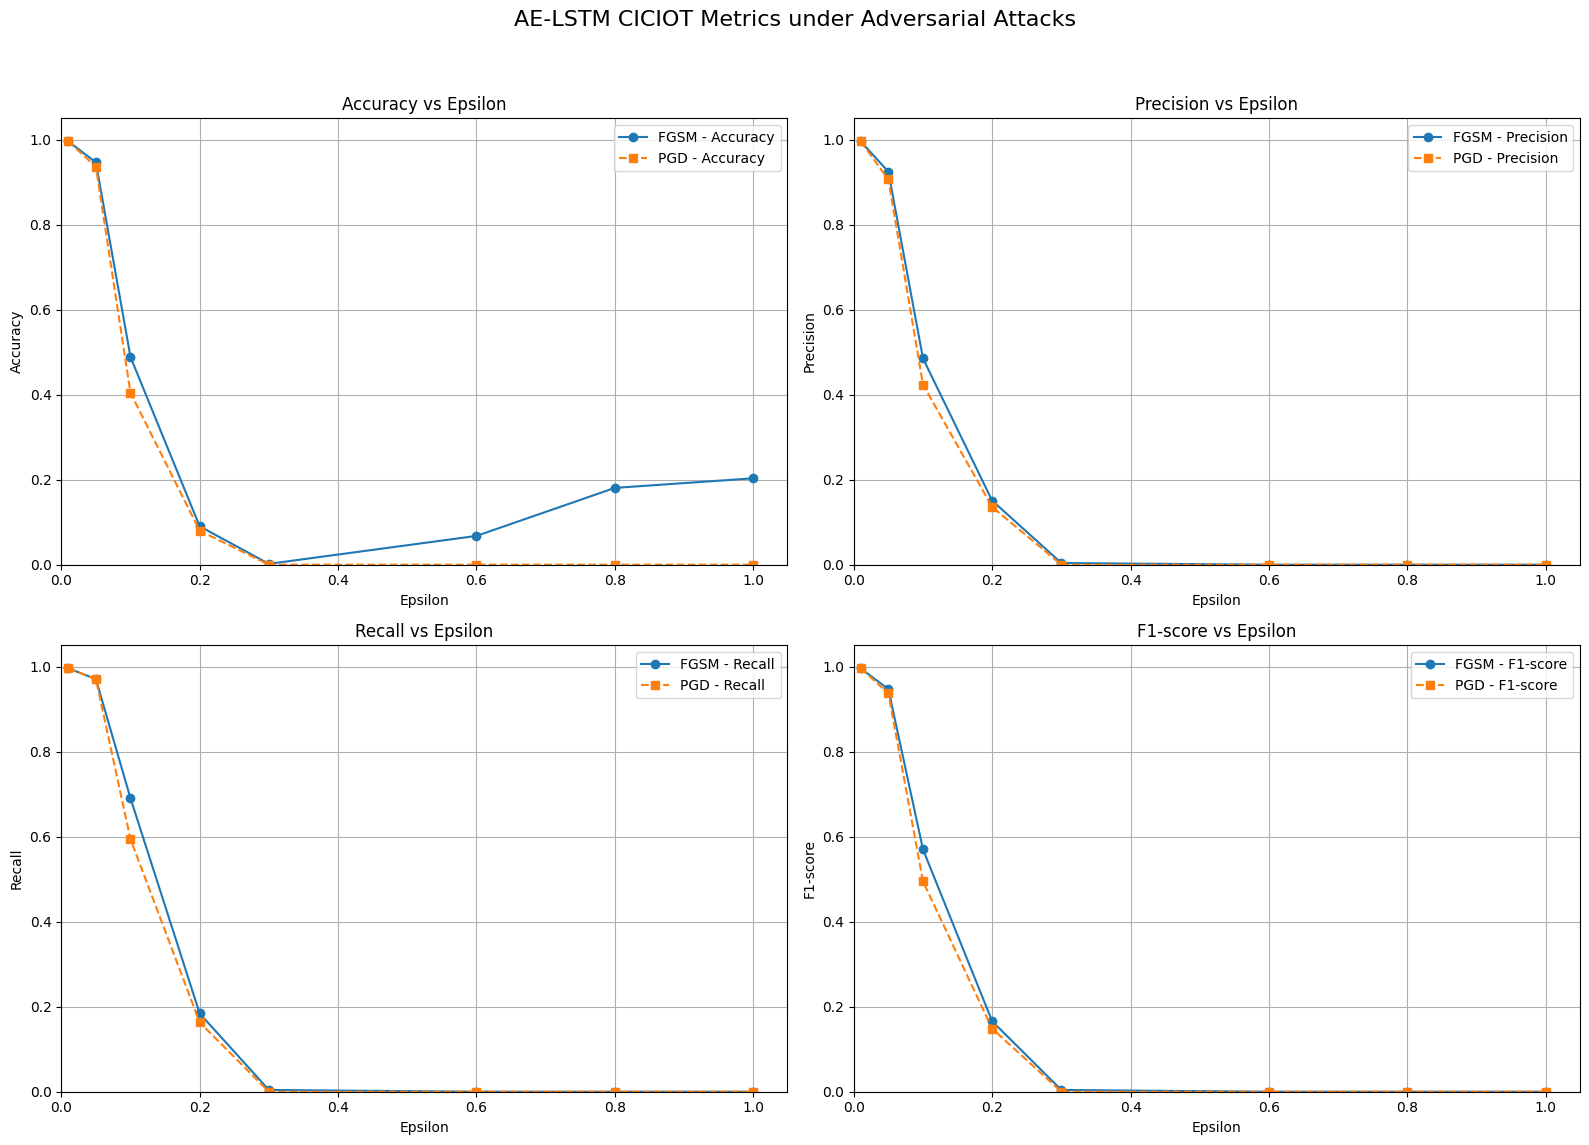

In [45]:
run_adversarial_evaluation(ae_lstm_loaded, "AE-LSTM", X_test[:500], Y_test[:500], epsilons, clip_vals, "../../results/CICIOT_updated/attacks/AE-LSTM")

## CNN

### FGSM

In [ ]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.estimators.classification import KerasClassifier

# attack_fgsm = fgsmAttack(estimator=classifier)

classifier = KerasClassifier(model=cnn_loaded, clip_values=(X_test.min(), X_test.max()))
preds_clean = classifier.predict(X_test[:2000])
labels_clean = (preds_clean > 0.5).astype(int).flatten()

# only keep correctly classified traffic (TP and TN)
correct = labels_clean == Y_test[:2000]
X_correct = X_test[:2000][correct]
Y_correct = Y_test[:2000][correct]

classifier = KerasClassifier(model=cnn_loaded, clip_values=(X_correct.min(), X_correct.max()))
print(X_correct.min(), X_correct.max())

epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0]

0.0 1.0


### FGSM (FastGradientMethod)

In [ ]:
# fgsm predictions
fgsm_acc, fgsm_prec, fgsm_rec, fgsm_f1 = [], [], [], []
start = time.time()
for i in range(len(epsilons)):
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=epsilons[i])
    adv_fgsm = attack_fgsm.generate(x=X_correct, y=Y_correct)
    preds_adv_fgsm = classifier.predict(adv_fgsm)
    labels_adv_fgsm = (preds_adv_fgsm > 0.5).astype(int).flatten()
    (acc, prec, rec, f1) = evaluate(Y_correct, labels_adv_fgsm, f"FGSM Attack - intenisty: {epsilons[i]*100}%")
    fgsm_acc.append(acc)
    fgsm_prec.append(prec)
    fgsm_rec.append(rec)
    fgsm_f1.append(f1)
    if i == 1.0 :
        fgsm_fpr, fgsm_tpr, fgsm_thresholds = roc_curve(Y_correct, labels_adv_fgsm)
        fgsm_roc_auc = auc(fgsm_fpr, fgsm_tpr)
print(f"FGSM Time: {time.time() - start:.2f} sec\n")

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(32, 2), output.shape=(32, 1)

### ProjectedGradientDescent

In [ ]:
# ProjectedGradientDescent predictions
pgd_acc, pgd_prec, pgd_rec, pgd_f1 = [], [], [], []
start = time.time()
for i in range(len(epsilons)):
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=epsilons[i], verbose=False)
    adv_pgd = attack_pgd.generate(x=X_correct, y=Y_correct)
    preds_adv_pgd = classifier.predict(adv_pgd)
    labels_adv_pgd = (preds_adv_pgd > 0.5).astype(int).flatten()
    (acc, prec, rec, f1) = evaluate(Y_correct, labels_adv_pgd, f"PGD Attack - intenisty: {epsilons[i]*100}%")
    pgd_acc.append(acc)
    pgd_prec.append(prec)
    pgd_rec.append(rec)
    pgd_f1.append(f1)
    if i == 1.0 :
        pgd_fpr, pgd_tpr, pgd_thresholds = roc_curve(Y_correct, labels_adv_pgd)
        pgd_roc_auc = auc(pgd_fpr, pgd_tpr)
print(f"PGD Time: {time.time() - start:.2f} sec\n")

--- PGD Attack - intenisty: 1.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 5.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 10.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 20.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 30.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 60.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 80.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- PGD Attack - intenisty: 100.0% ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

PGD Time: 57.98 sec



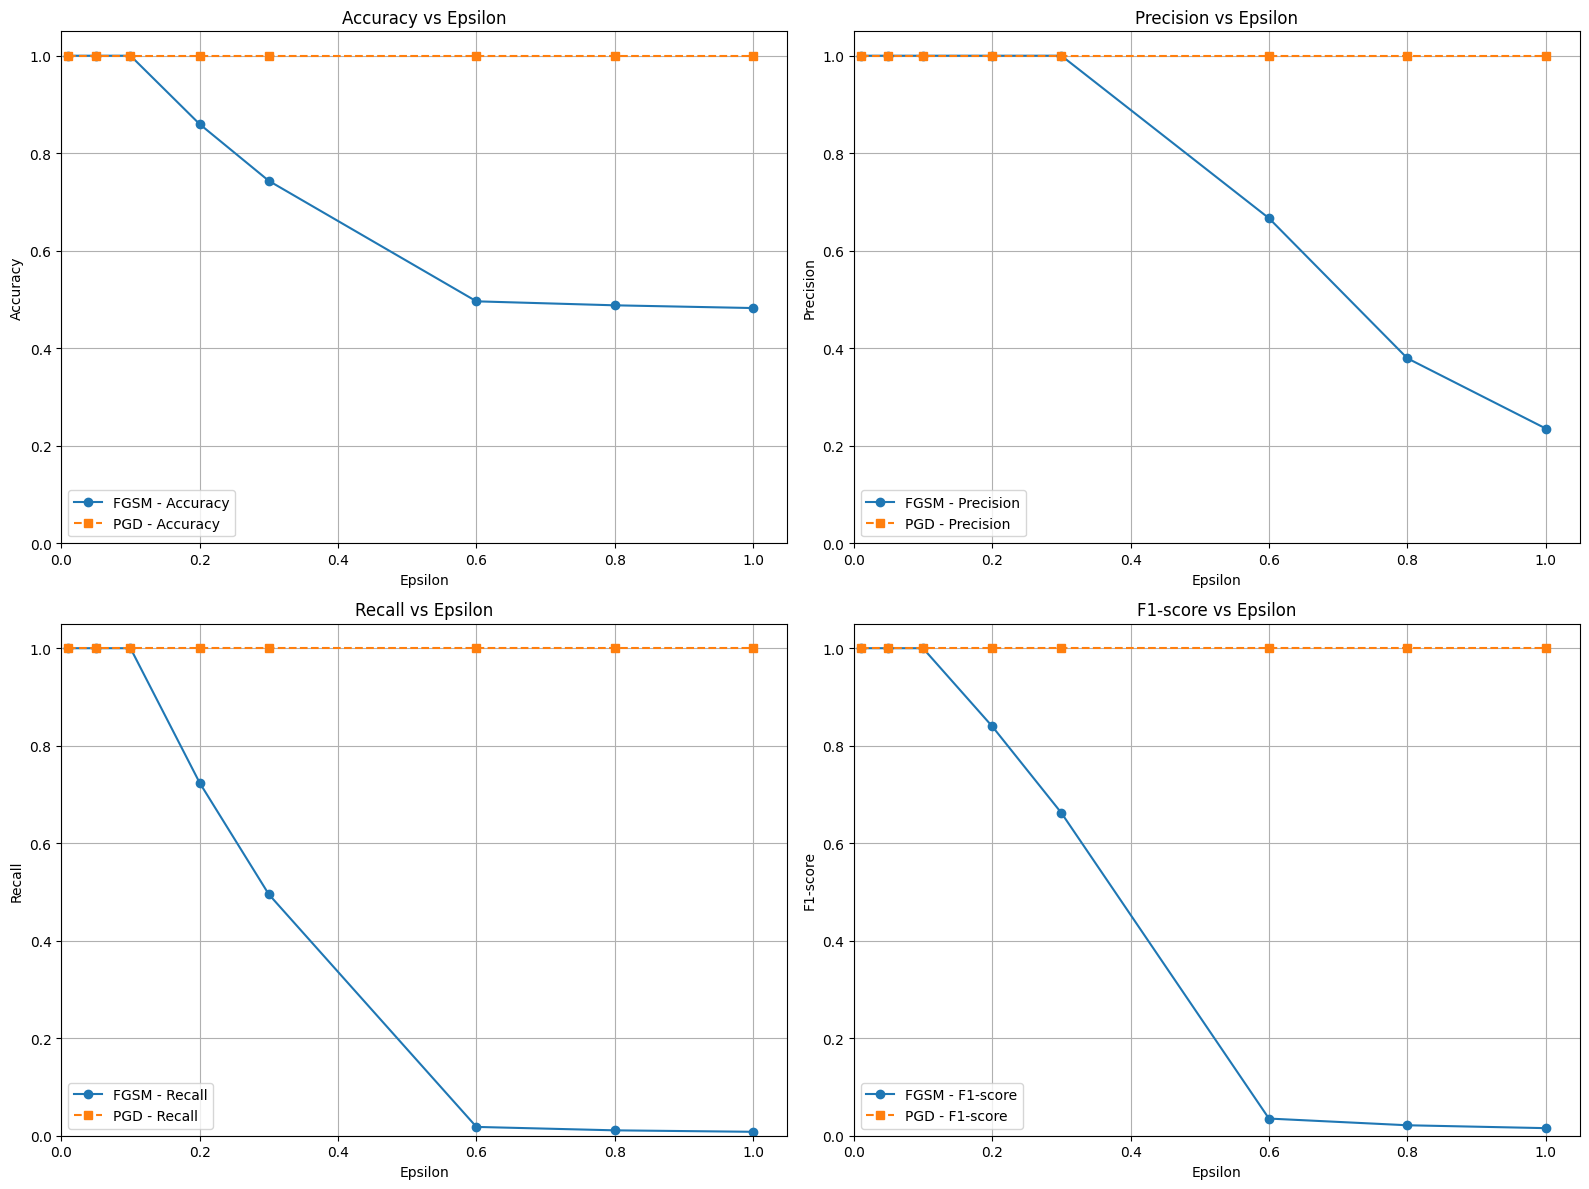

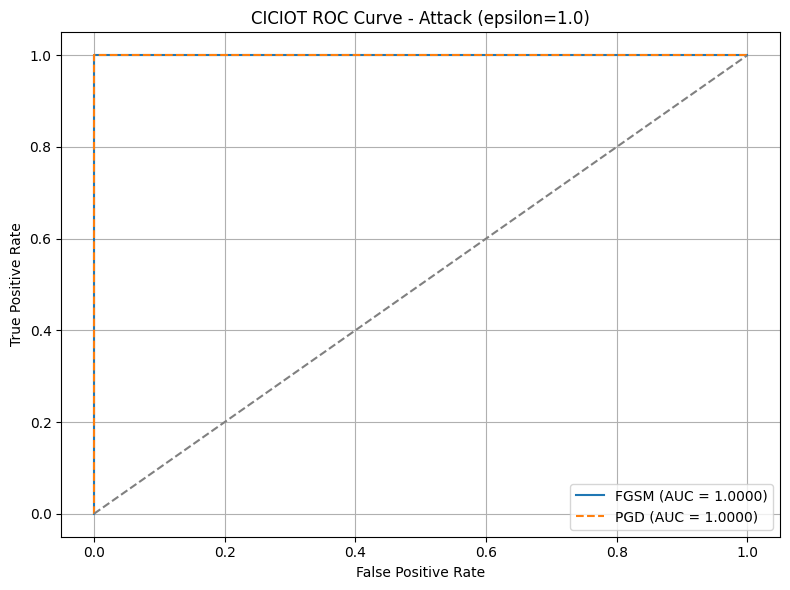

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(epsilons, fgsm_acc, label='FGSM - Accuracy', marker='o', linestyle='-', color='tab:blue')
axes[0, 0].plot(epsilons, pgd_acc, label='PGD - Accuracy', marker='s', linestyle='--', color='tab:orange')
axes[0, 0].set_xlabel('Epsilon')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Epsilon')
axes[0, 0].set_xlim(left=0.0)
axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision
axes[0, 1].plot(epsilons, fgsm_prec, label='FGSM - Precision', marker='o', linestyle='-', color='tab:blue')
axes[0, 1].plot(epsilons, pgd_prec, label='PGD - Precision', marker='s', linestyle='--', color='tab:orange')
axes[0, 1].set_xlabel('Epsilon')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision vs Epsilon')
axes[0, 1].set_xlim(left=0.0)
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Recall
axes[1, 0].plot(epsilons, fgsm_rec, label='FGSM - Recall', marker='o', linestyle='-', color='tab:blue')
axes[1, 0].plot(epsilons, pgd_rec, label='PGD - Recall', marker='s', linestyle='--', color='tab:orange')
axes[1, 0].set_xlabel('Epsilon')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall vs Epsilon')
axes[1, 0].set_xlim(left=0.0)
axes[1, 0].set_ylim(0, 1.05)
axes[1, 0].legend()
axes[1, 0].grid(True)

# F1-score
axes[1, 1].plot(epsilons, fgsm_f1, label='FGSM - F1-score', marker='o', linestyle='-', color='tab:blue')
axes[1, 1].plot(epsilons, pgd_f1, label='PGD - F1-score', marker='s', linestyle='--', color='tab:orange')
axes[1, 1].set_xlabel('Epsilon')
axes[1, 1].set_ylabel('F1-score')
axes[1, 1].set_title('F1-score vs Epsilon')
axes[1, 1].set_xlim(left=0.0)
axes[1, 1].set_ylim(0, 1.05)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_metrics_CNN.png', dpi=1000)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fgsm_fpr, fgsm_tpr, label=f'FGSM (AUC = {fgsm_roc_auc:.4f})', color='tab:blue')
plt.plot(pgd_fpr, pgd_tpr, label=f'PGD (AUC = {pgd_roc_auc:.4f})', linestyle='--', color='tab:orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CICIOT ROC Curve - Attack (epsilon=1.0)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('../../results/attack/CICIOT_ROC_CNN_eps1.0.png', dpi=1000)
plt.show()

### Trying Foolbox

In [ ]:
fmodel = fb.TensorFlowModel(cnn_loaded, bounds=(X_test.min(), X_test.max()))

# attack = fb.attacks.HopSkipJumpAttack()
attack = fb.attacks.BoundaryAttack()
# attack = fb.attacks.FGSM()


epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1.0]
x = tf.constant(X_test[:5].astype(np.float32))
y = tf.constant(Y_test[:5].astype(np.int64))

advs, clipped, success = attack(fmodel, x, y, epsilons=epsilons)

for i, eps in enumerate(epsilons):
    print(f"Epsilon {eps:.2f} — Success rate: {np.mean(success[i]):.2%}")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/home/bossantm/anaconda3/envs/dl-attack-env/lib/python3.9/site-packages/foolbox/attacks/blended_noise.py:85: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (3 / 5).
  warnings.warn(


ValueError: init_attack failed for 2.0 of 5 inputs